# Ford Go Bike Dataset Analysis 
## by Jin Zhou

## Preliminary Wrangling

This dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area from 01/01/2018 to 12/31/2018 for the whole one year. 

In [1]:
# import all packages and set plots to be embedded inline
import os, zipfile
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import warnings,sys
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
year_data = [x for x in range(201801, 201813)]
# file download link as https://s3.amazonaws.com/baywheels-data/201801-fordgobike-tripdata.csv.zip
for year in year_data:
    url = f"https://s3.amazonaws.com/baywheels-data/{year}-fordgobike-tripdata.csv.zip"    
    response = requests.get(url)
    with open(f"data/{year}-fordgobike-tripdata.csv.zip", mode = "wb") as file:
        file.write(response.content)

In [3]:
# unzip these files to csv
files = os.listdir('data/')
for i in files:
    if i.endswith(".zip"):
        with zipfile.ZipFile(f"./Data/{i}",'r') as zip_ref:
            zip_ref.extractall("./Data")

In [4]:
# readin csv to a large dataframe
data_list = []
files = os.listdir('data/')
for i in files:
    # since zip file and macosx folder and zip file exist in the data folder, I will not read in them in pandas. 
    if i.endswith('.csv'):
        df = pd.read_csv('data/'+i)
        data_list.append(df)
df = pd.concat(data_list, axis = 0, sort=False)
df.shape

(1863721, 14)

In [5]:
### Data Assessing
df.to_csv('all_data.csv', index = False)
data = pd.read_csv('all_data.csv')
data.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip
0,598,2018-02-28 23:59:47.0970,2018-03-01 00:09:45.1870,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114.0,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,No
1,943,2018-02-28 23:21:16.4950,2018-02-28 23:36:59.9740,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,No
2,18587,2018-02-28 18:20:55.1900,2018-02-28 23:30:42.9250,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,No
3,18558,2018-02-28 18:20:53.6210,2018-02-28 23:30:12.4500,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,No
4,885,2018-02-28 23:15:12.8580,2018-02-28 23:29:58.6080,308.0,San Pedro Square,37.336802,-121.894090,297.0,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,Yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 14 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
dtypes: float64(6), int64(2), object(6)
memory usage: 199.1+ MB


As we can see from above information, some data type is not correct, time should be timestamp form, station_id, bikeid should be object. 

In [7]:
# print out each column what is the ratio of null values.

for i in df.columns:
    print(i, pd.isnull(df[i]).sum()/df.shape[0])

duration_sec 0.0
start_time 0.0
end_time 0.0
start_station_id 0.006315859509014493
start_station_name 0.006315859509014493
start_station_latitude 0.0
start_station_longitude 0.0
end_station_id 0.006315859509014493
end_station_name 0.006315859509014493
end_station_latitude 0.0
end_station_longitude 0.0
bike_id 0.0
user_type 0.0
bike_share_for_all_trip 0.0


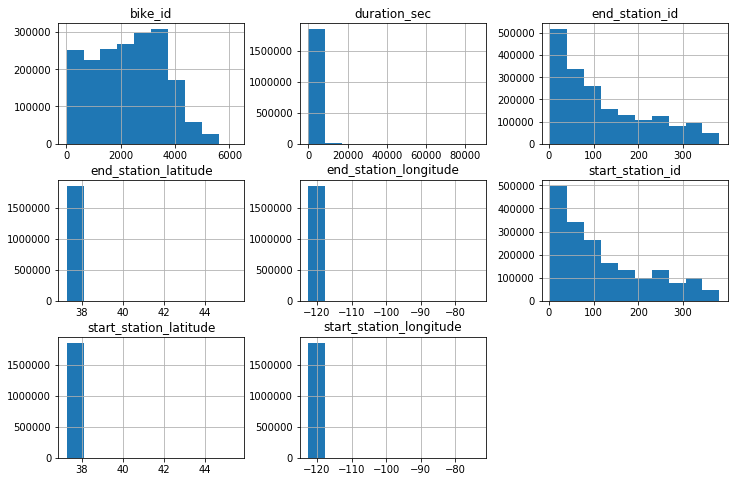

In [8]:
df.hist(figsize = (12, 8));

Seen from above histogram of numerical figure, we can see that duration are most short time, although there are some outliers. Same for the station longitude and lattitude, some outliers exist in this datasets. It could mean that these recorded location longitude/lattitude is not correct, and should be dropped. 
Eg. most lattidue is 37, but max is around 45, in map, it means some place very far away. Most longitude is -120, max is -70. The datasets is within SanFrancisco area, so it lattidude and longtitude should not differ that much.


In [9]:
start_id = sorted(df['start_station_id'].drop_duplicates().dropna().astype(int))
end_id  = sorted(df['end_station_id'].drop_duplicates().dropna().astype(int))
start_id == end_id, len(start_id)

(True, 331)

Now we can see that this dataset contains 331 station_ids for both start and end positions.


In [10]:
stations = df[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().dropna()
stations['start_station_id'] = stations['start_station_id'].astype(int)
stations.shape, stations.drop_duplicates().shape

((358, 4), (358, 4))

This means that there are 331 stations, but including longitude and lattitude, there are 358 different stations. Some stations changed their longitude and lattitude.

In [11]:
stations['start_station_id'].value_counts()

212    3
233    3
208    3
244    3
205    3
      ..
246    1
247    1
248    1
249    1
3      1
Name: start_station_id, Length: 331, dtype: int64

In [12]:
stations[stations['start_station_id']==212]

,start_station_id,start_station_name,start_station_latitude,start_station_longitude
544,212,Mosswood Park,37.824931,-122.260479
295,212,Webster St at MacArthur Blvd (Temporary Location),37.825008,-122.261649
512,212,Mosswood Park,37.824893,-122.260437


In [13]:
stations[stations['start_station_id']==233]


,start_station_id,start_station_name,start_station_latitude,start_station_longitude
429,233,12th St at 4th Ave,37.795812,-122.255555
3913,233,4th Ave at E 12th St (Temporary Location),37.795913,-122.255547
1127,233,E 12th St at 4th Ave,37.795812,-122.255555


Which proves that some stations have changed their location temporary during sometime of year, thus they have different longitude and lattitude 


In [14]:
stations1 = df[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().dropna()
stations1['end_station_id'] = stations1['end_station_id'].astype(int)
stations1.shape, stations1.drop_duplicates().shape

((358, 4), (358, 4))

In [15]:
stations1['end_station_id'].value_counts() # same for the end station

212    3
233    3
208    3
244    3
205    3
      ..
246    1
247    1
248    1
249    1
3      1
Name: end_station_id, Length: 331, dtype: int64

## Assessment Summary:
#### Quality issue

* Missing values in start/end, station_id, station_name.
* start_time/end_time data type is not correct.
* all ids, station_id, bike_id should be object
* station longitude/lattitude has some outliers, which need to be identified. They are not reasonable within datasets.
* Some stations temporaty changed location during the year. So there are more than one longitude and lattitude locations. Same can be seen from station name. 

#### Tidiness issue

Not found yet.

## Data Cleaning

#### Define:
As we can see from above, station_id, station_name has some null values. But since these null stations have longitude and lattitude, can we infer their station id? Or is it safe for us to keep remove these values?

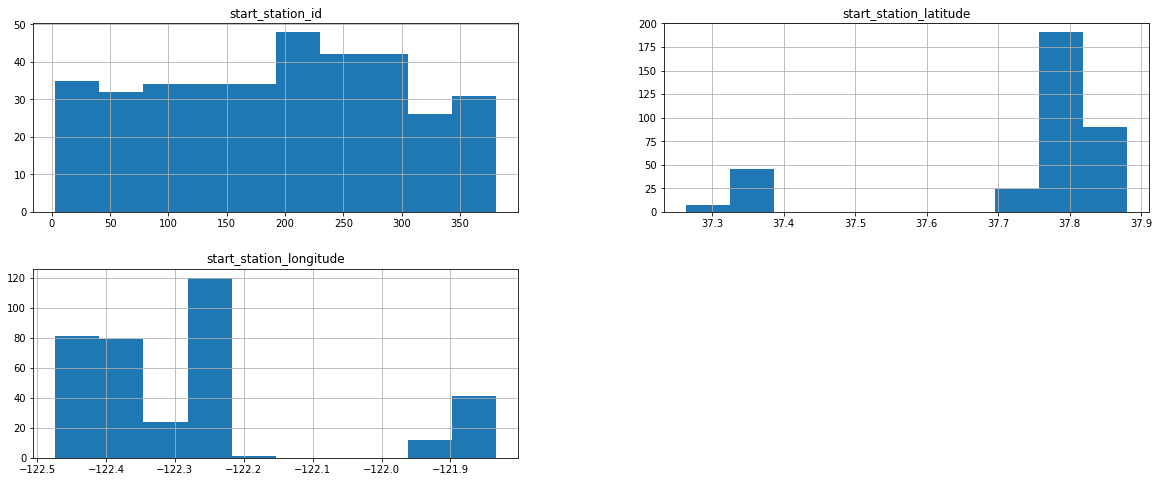

In [16]:
# CODE:
stations.hist(figsize=(20, 8));

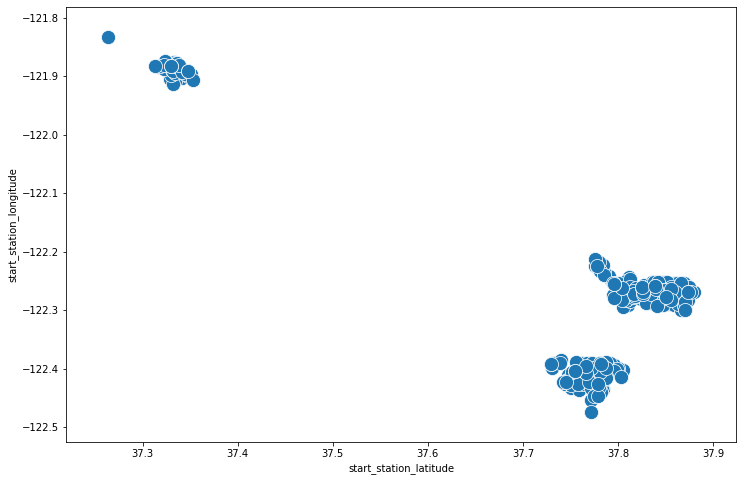

In [17]:
plt.figure(figsize = (12,8))
sns.scatterplot(data = stations, x = "start_station_latitude", y = "start_station_longitude", s = 200);

Now we can clearly see that longitude and lattitude of the station has no more outliers, and they seems to form into three different clusters, possibly three different cities in bay area. After we drop the stations which has no station_id in the datasets, i.e. original datasets with station_id is null, has outliers with longitude and lattitude.  


In [18]:
df = df[~df['start_station_id'].isnull()]
df.shape

(1851950, 14)

In [19]:
# TEST:
for i in df.columns:
    print(i, pd.isnull(df[i]).sum()/df.shape[0])  # now the new datasets has no more missing values.

duration_sec 0.0
start_time 0.0
end_time 0.0
start_station_id 0.0
start_station_name 0.0
start_station_latitude 0.0
start_station_longitude 0.0
end_station_id 0.0
end_station_name 0.0
end_station_latitude 0.0
end_station_longitude 0.0
bike_id 0.0
user_type 0.0
bike_share_for_all_trip 0.0


#### Define: 

Time format is not correct, id format is not correct.

In [20]:
# CODE: 
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

print(df['start_time'].min(),  df['start_time'].max())

df['start_station_id'] = df['start_station_id'].astype(int).astype(str)
df['end_station_id'] = df['end_station_id'].astype(int).astype(str)
df['bike_id'] = df['bike_id'].astype(int).astype(str)

2018-01-01 00:01:53.847000 2018-12-31 23:59:12.097000


In [21]:
# TEST:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851950 entries, 0 to 131168
Data columns (total 14 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
bike_share_for_all_trip    object
dtypes: datetime64[ns](2), float64(4), int64(1), object(7)
memory usage: 211.9+ MB


In [22]:
df.describe()

,duration_sec,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,1.851950e+06,1.851950e+06,1.851950e+06,1.851950e+06,1.851950e+06
mean,8.529994e+02,3.776904e+01,-1.223521e+02,3.776917e+01,-1.223515e+02
std,2.339450e+03,1.007719e-01,1.186128e-01,1.006298e-01,1.180515e-01
min,6.100000e+01,3.726331e+01,-1.224737e+02,3.726331e+01,-1.224737e+02
25%,3.500000e+02,3.777106e+01,-1.224116e+02,3.777143e+01,-1.224099e+02
50%,5.550000e+02,3.778107e+01,-1.223974e+02,3.778127e+01,-1.223971e+02
75%,8.700000e+02,3.779728e+01,-1.222894e+02,3.779728e+01,-1.222914e+02
max,8.636600e+04,3.788022e+01,-1.218333e+02,3.788022e+01,-1.218333e+02


In [23]:
df.to_csv('bike_data_cleaned.csv', index = False)

### What is the structure of your dataset?
dataframe with timestamp of when/where the trip start and end, station_id, bike_id, duration of trip. 


### What is/are the main feature(s) of interest in your dataset?
number of trips by riders per station. During of the trip. 


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
Time/location of the trip will be included.


## Exploratory Data Analysis

When are most trips taken in terms of time of day, day of the week, or month of the year?


How long does the average trip take?  Does the above depend on if a user is a subscriber or customer?

In [24]:
df = pd.read_csv('bike_data_cleaned.csv')

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_station_id'] = df['start_station_id'].astype(int).astype(str)
df['end_station_id'] = df['end_station_id'].astype(int).astype(str)
df['bike_id'] = df['bike_id'].astype(int).astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851950 entries, 0 to 1851949
Data columns (total 14 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
bike_share_for_all_trip    object
dtypes: datetime64[ns](2), float64(4), int64(1), object(7)
memory usage: 197.8+ MB


In [25]:
df['month'] = df['start_time'].map(lambda x: x.month)
df['hour'] = df['start_time'].map(lambda x: x.hour)
df['weekday'] = df['start_time'].map(lambda x: x.weekday())

In [26]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,month,hour,weekday
0,598,2018-02-28 23:59:47.097,2018-03-01 00:09:45.187,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,-122.402570,1035,Subscriber,No,2,23,2
1,943,2018-02-28 23:21:16.495,2018-02-28 23:36:59.974,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,-122.408531,1673,Customer,No,2,23,2
2,18587,2018-02-28 18:20:55.190,2018-02-28 23:30:42.925,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3498,Customer,No,2,18,2
3,18558,2018-02-28 18:20:53.621,2018-02-28 23:30:12.450,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,15,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,3129,Customer,No,2,18,2
4,885,2018-02-28 23:15:12.858,2018-02-28 23:29:58.608,308,San Pedro Square,37.336802,-121.894090,297,Locust St at Grant St,37.322980,-121.887931,1839,Subscriber,Yes,2,23,2


In [27]:
## Since before we see from longitude/lattitude that the data seems form three cluster, maybe they belong to three different cities in bay area.
## We can use k-mean clustering.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(stations[[ "start_station_latitude", "start_station_longitude"]])
stations['cluster'] = kmeans.labels_

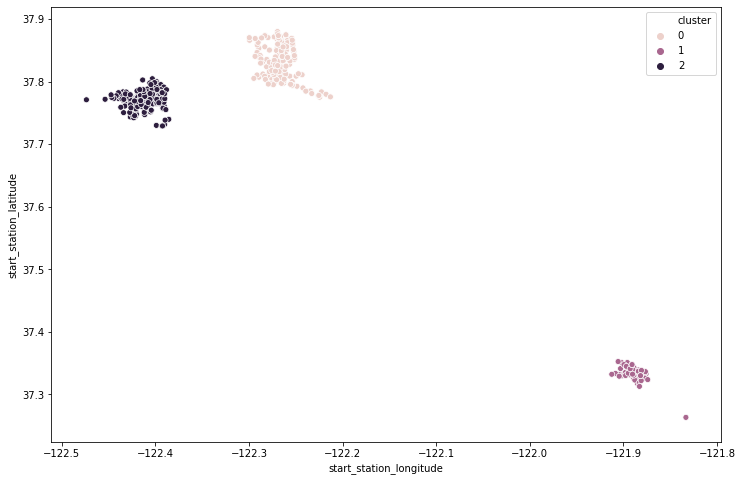

In [28]:
plt.figure(figsize = (12,8))
sns.scatterplot(data = stations, x = "start_station_longitude", y = "start_station_latitude", hue="cluster");

In [29]:
kmeans.cluster_centers_ # cluster 0 is Oakland, cluster 1 is Sanjose, cluster 2 is SanFrancisco

array([[  37.83058725, -122.26604033],
       [  37.33343399, -121.88909517],
       [  37.77166847, -122.41160577]])

In [30]:
dicts = {0:'Oakland', 2:'San Francisco', 1:'San Jose'} ## note this may need to change
# create mapping between station_id and cluster
sta_clu = {}
for i in zip(stations['start_station_id'], stations['cluster']): 
    sta_clu[str(i[0])] = i[1]
# create start/end station city 
df['start_station_city'] = df['start_station_id'].map(lambda x: dicts[sta_clu[x]])
df['end_station_city']   = df['end_station_id'].map(lambda x: dicts[sta_clu[x]])

## Univariate Exploration

### Investigate the trip duration seconds, counts of trip, customer/subscriber trip counts, hourly/day of week/monthly trip counts. Also, city of trip counts.

In the following plot, I will analyze the duration seconds for each trip.

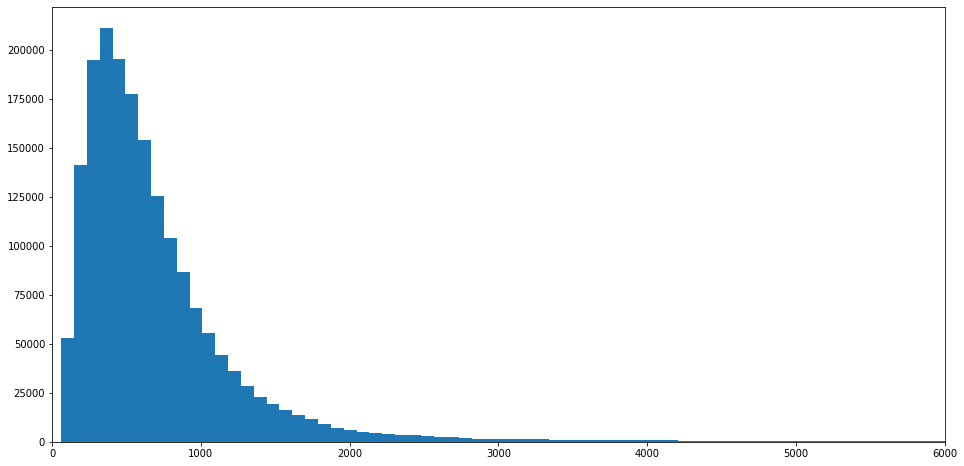

In [31]:
plt.figure(figsize = (16, 8))
plt.xlim((0, 6000))
plt.hist(df['duration_sec'], bins = 1000);

In [32]:
df['duration_sec'].median() # as we can see the median of duration is only around 555 seconds.  

555.0

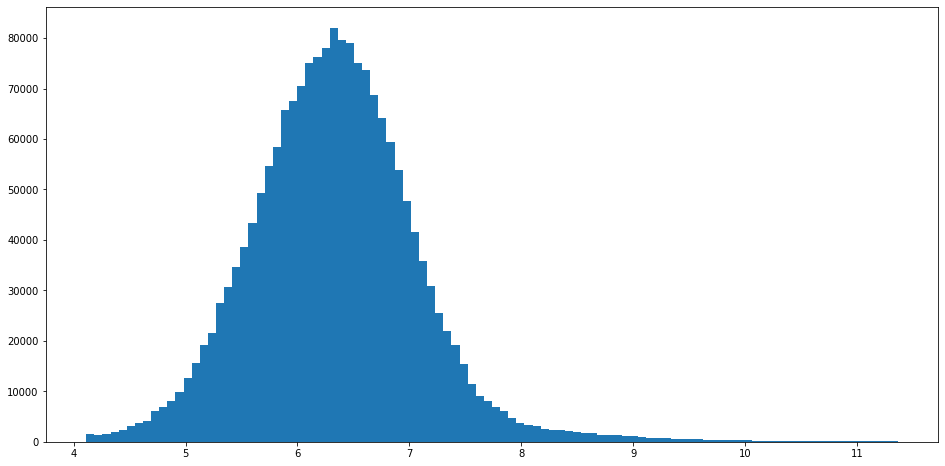

In [33]:
# if we plot the log of duration_sec, the distribution looks more than normal distribution. 
plt.figure(figsize = (16, 8))
plt.hist(np.log(df['duration_sec']), bins = 100);

In [34]:
# In the following analysis I will remove the outlier where duration_sec > 5000.
rdf = df[df['duration_sec']<=5000]
rdf.shape[0]/df.shape[0] # just remove 1.1% of data 

0.9887534760657685

What are the counts of trips of customer vs subscriber?

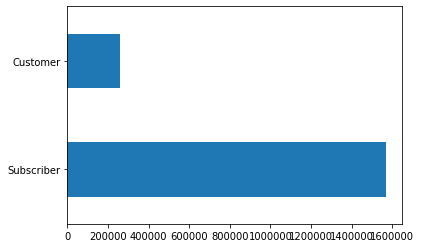

In [35]:
rdf['user_type'].value_counts().plot.barh(); # there are much more subscriber than customer

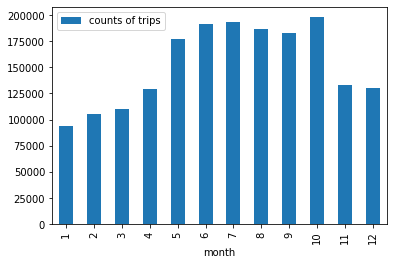

In [36]:
rdf[['month', 'start_time']].groupby('month').count(
    ).rename(columns = {'start_time':'counts of trips'}).plot.bar(); 
# more trips took place from May to Oct. Summer has more trips 

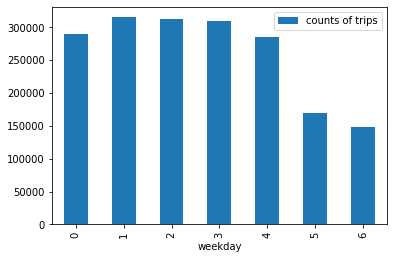

In [37]:
rdf[['weekday', 'start_time']].groupby('weekday').count(
    ).rename(columns = {'start_time':'counts of trips'}).plot.bar();
# More trips happens during the week day, instead of weekend. 
# possible that more people use bike for work.  

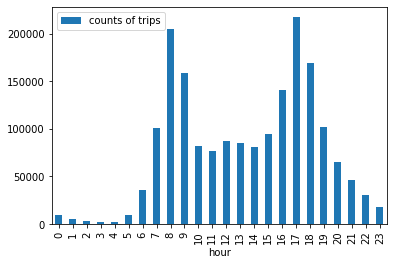

In [38]:
rdf[['hour', 'start_time']].groupby('hour').count().rename(columns = {'start_time':'counts of trips'}).plot.bar();
# More trips happens during morning around 8am or afternoon around 5pm. 
# possible that more people use bike for going to work and returning home.
# other time there are less trips.

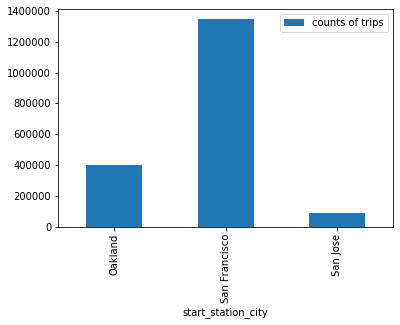

In [39]:
rdf[['start_station_city', 'start_time']].groupby('start_station_city').count(
).rename(columns = {'start_time':'counts of trips'}).plot.bar();

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

As we can see that the duration_secs is highly right skewed, due to several users the trip duration is more than 4000 seconds, while most users duration is less than 1000 seconds. So we perform the np.log transform, then the duration secs will be more like normal distribution. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

For other features, 'customer type', 'day of week', 'month', 'hour', I found some patterns with the counts of trips. 
* It's easy for us to see that more trips are with subcribers. 
* Week day has more trips than weekend. 
* Summer time there are more trips than other seasons. 
* Most trips happended when people use them to go to work or get off from work.

I also create the city name depends on the stations longitude and lattitude, basically there are three cities in this datasets. "SAN FRANCISCO", "OAKLAND", "SAN JOSE", Where "SAN FRANCISCO" has most number of trips happens. With these informations, it will be easy to see where most trips happens, instead of looking at the station id.   

## Bivariate Exploration

In this section, investigate relationships between pairs of variables in bike dataset.But mainly focus on the trip duration analysis. 

#### First, I will analyze the pair of start_station_city and end_station_city. How many of them a inter-city trips, how many are intra-city trips.

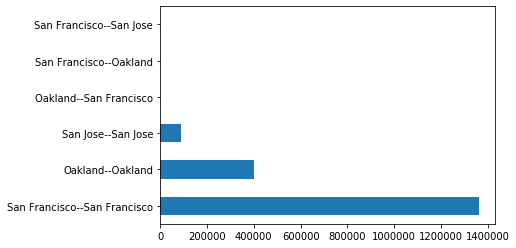

In [40]:
(df['start_station_city'] + '--' + df['end_station_city']).value_counts().plot.barh()

In [41]:
(df['start_station_city'] + '--' + df['end_station_city']).value_counts()

San Francisco--San Francisco    1362573
Oakland--Oakland                 401795
San Jose--San Jose                87486
Oakland--San Francisco               68
San Francisco--Oakland               27
San Francisco--San Jose               1
dtype: int64

In [42]:
## As we can see from above, most trips are within the same city. 
## some out city trips are between San Francisco and Oak Land, which was not too far way.
## The longest trip is between San Francisco and San Jose. The trip last for 6 hours. 
df[(df['start_station_city']=='San Francisco') & (df['end_station_city']=='San Jose')]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip,month,hour,weekday,start_station_city,end_station_city
1617299,21836,2018-03-29 14:25:47.670,2018-03-29 20:29:44.284,16,Steuart St at Market St,37.79413,-122.39443,303,San Pedro St at Hedding St,37.352601,-121.905733,319,Customer,No,3,14,3,San Francisco,San Jose


 By looking at the top 10 start/end cities, where the counts of the trips happen most. San Francisco trips have most counts than other cities, like oakland and San Jose. 

#### Now we can look at the which stations_id are the most popular within 3 different cities.  The variables are start_station_id, start_station_city vs trip counts.

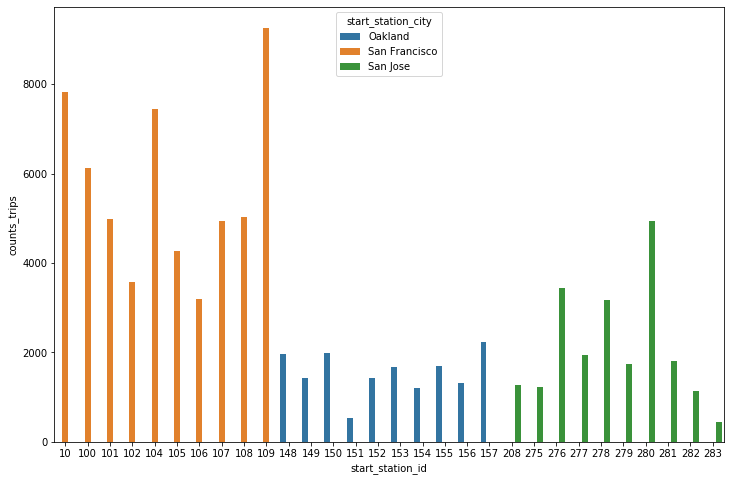

In [43]:
# Top 10 start station trip counts for each city. 
gp_start = df[['start_station_id', 'start_time', 'start_station_city']].groupby(['start_station_city', 'start_station_id']).count(
                                                                        ).reset_index()
gp_start.columns = ['start_station_city', 'start_station_id', 'counts_trips']
top10 = gp_start.groupby(['start_station_city']).head(10)
plt.figure(figsize = (12, 8))
sns.barplot(data = top10, x = 'start_station_id', y = 'counts_trips', hue = 'start_station_city');

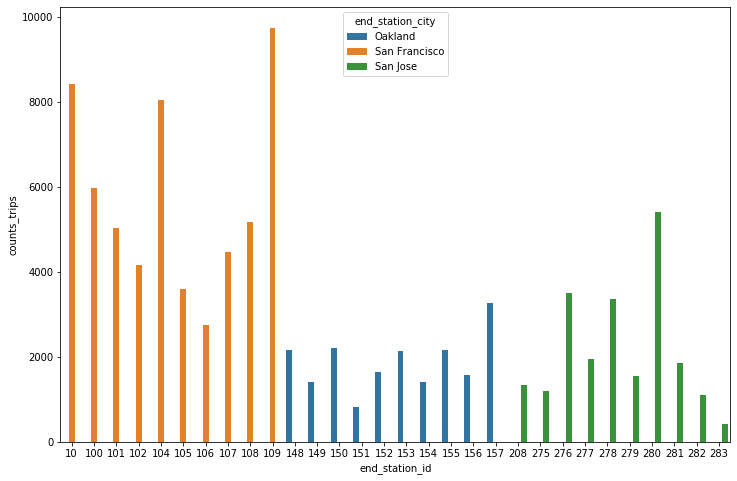

In [44]:
# Top 10 end station trip counts for each city. 
gp_end = df[['end_station_id', 'end_time', 'end_station_city']].groupby(['end_station_city', 'end_station_id']).count().reset_index()
gp_end.columns = ['end_station_city', 'end_station_id', 'counts_trips']

top10 = gp_end.groupby(['end_station_city']).head(10)
plt.figure(figsize = (12, 8))
sns.barplot(data = top10, x = 'end_station_id', y = 'counts_trips', hue = 'end_station_city');

Now we can see that counts of trip station_id for San Francisco is higher than San Jose and Oakland. And it is quite consistent that the top 10 stations for each city has high counts for both start and end city.

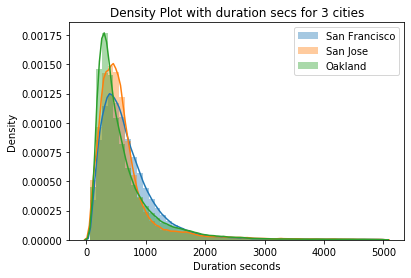

In [45]:
## Now plot the trip duration density plots  for 3 different cities.
for i in rdf['start_station_city'].unique():
    sns.distplot(rdf.loc[rdf['start_station_city']==i, 'duration_sec'], kde=True, label = i)

plt.legend()
plt.title('Density Plot with duration secs for 3 cities')
plt.xlabel('Duration seconds')
plt.ylabel('Density'); 
# we can see that it looks like San Francisco and San Jose has higher median duration secs than Oakland. 

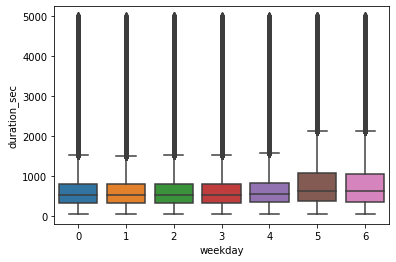

In [46]:
sns.boxplot(x = "weekday", y = "duration_sec", data = rdf);

#### If we just plot the duration secconds vs. week of day, because the tail of duration seconds is too high, it is hard for us to see the trend. 
#### Plot log_duration_secs vs week of day, eventhough the tail looks smaller, still the trend is hard to see. 

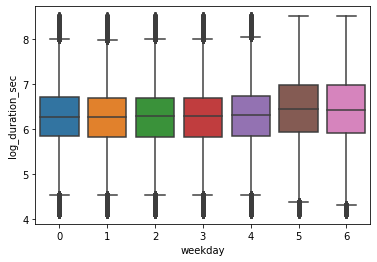

In [47]:
rdf['log_duration_sec'] = np.log(rdf['duration_sec'])
rdf['date'] = rdf['start_time'].map(lambda x: x.date)
sns.boxplot(x = "weekday", y = "log_duration_sec", data = rdf);

#### We can group the data on week of day and month, then get the median of duration seconds per group, maybe we can see the trend. 

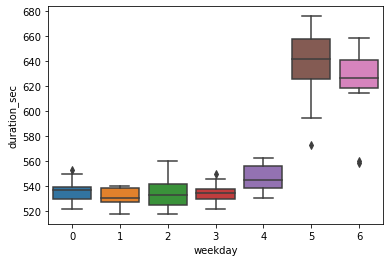

In [48]:
sns.boxplot(x = "weekday", y = "duration_sec", 
           data = rdf.groupby(["weekday", "month"], as_index = False).median());

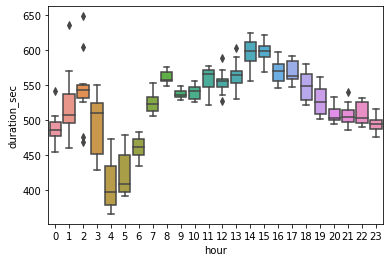

In [49]:
sns.boxplot(x = "hour", y = "duration_sec", 
           data = rdf.groupby(["hour", "month"], as_index = False).median());

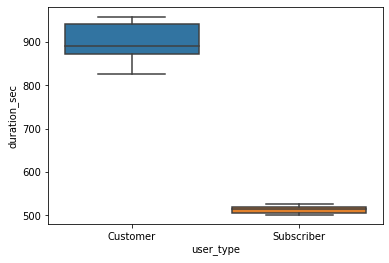

In [50]:
sns.boxplot(x = "user_type", y = "duration_sec", 
           data = rdf.groupby(["user_type", "month"], as_index = False).median());

From above visualization, we can see that:
* median duration secs is only around 540 secs on week day, while on weekend, the median duration will be 640 seconds. 
* median duration secs is relative lower on the beginning of day (with large fluctuation), while on weekend, the median duration will be higher around 3pm. Then lower again till 5pm. 
* For user type, we can see that regular customer, duration secs median is 900 secs. While subscriber take less time, median is 500 seconds, possibly means that subscribers use bike for work, thus, less fluctuation than regular customer.  

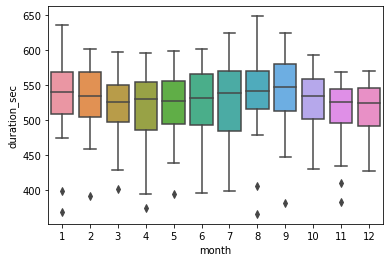

In [51]:
sns.boxplot(x = "month", y = "duration_sec", 
           data = rdf.groupby(["month", "hour"], as_index = False).median());

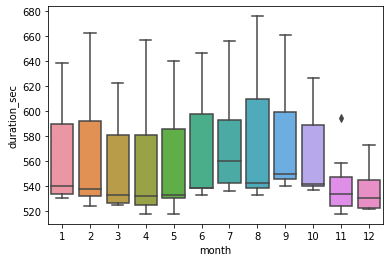

In [52]:
sns.boxplot(x = "month", y = "duration_sec", 
           data = rdf.groupby(["month", "weekday"], as_index = False).median());

As I try to plot the boxplot of duration secs per month, either aggregate by weekday or hour, the duration of secs do not change too much. Thus month is less associated with duration secs. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* For user type, we can see that regular customer, duration secs median is 900 secs. While subscriber take less time, median is 500 seconds, possibly means that subscribers use bike for work, thus, less fluctuation than regular customer.  
* median duration secs is only around 540 secs on week day, while on weekend, the median duration will be 640 seconds. 
* median duration secs is relative lower on the beginning of day (with large fluctuation), while on weekend, the median duration will be higher around 3pm. Then lower again till 5pm. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Either aggregate by weekday or hour, the duration of secs do not change too much. Thus month is less correlated with duration secs. 

## Multivariate Exploration

Now we include 3 variables to understand the duration secs. 

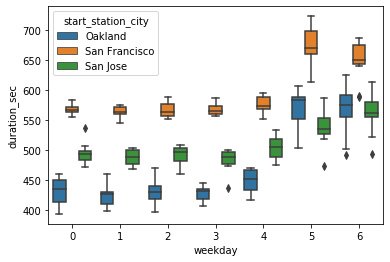

In [53]:
sns.boxplot(x = "weekday", y = "duration_sec", 
           data = rdf.groupby(["weekday", "month", 'start_station_city'], as_index = False).median(), 
           hue = 'start_station_city');

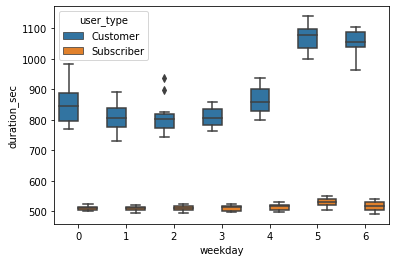

In [54]:
sns.boxplot(x = "weekday", y = "duration_sec", 
           data = rdf.groupby(["weekday", "month", 'user_type'], as_index = False).median(), 
           hue = 'user_type');

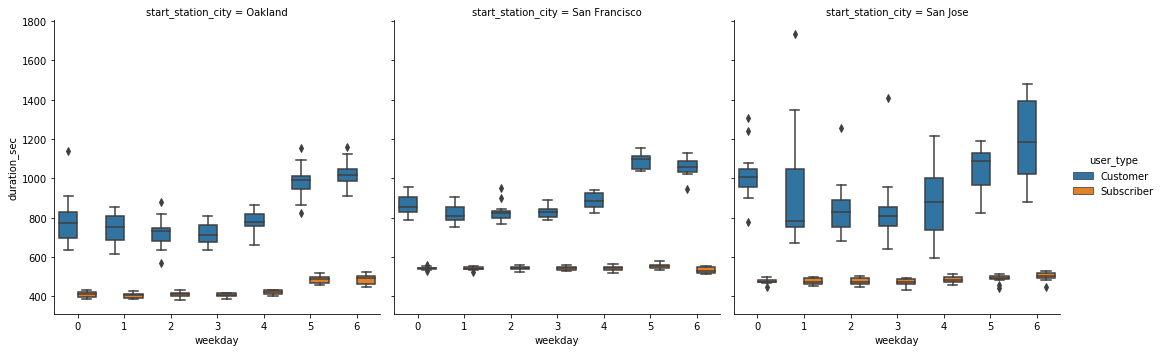

In [55]:
sns.catplot(x = "weekday", y = "duration_sec", 
           data = rdf.groupby(["weekday", 'month', 'user_type', 'start_station_city'], as_index = False).median(), 
           hue = 'user_type', col = 'start_station_city', kind='box');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

* For all the three cities, we both see the trend that the median duration secs is lower during week day than weekends, with clear trend that median duration for San Francisco is highest, then Oakland, followed by San Jose. The trend seems true for all 7 days of the week. 

* For subscribers, the median trip duration secs change during the week of day is relatively small. Unlike customers, the median trip duration secs have a trend that is lower on week day than weekends. 

* If we consider three variable 'start_station_city', 'week_of_day', 'user_type' how they together effect duration secs. In oakland, median duration secs seems have the trend of increasing duration secs for both subscriber and customer. While it is not true for other cities, like San Francisco and San Jose. San Francisco and San Jose subscriber median trip duration secs is less changing with week of day. San Jose the customer median trip duration secs trend for weekend and week day is not obvious than other two cities.

### Were there any interesting or surprising interactions between features?

As discussed above there is interaction between 'week_of_day', 'user_type', it is stronger for user_type = 'subscriber', where inital trend of median duration secs vs week_day is lost. If we add 'start_station_city', it will make all these trends less obvious. 

In [56]:
rdf.to_csv('clean_bike_data_added_new_feature.csv', index = False)